<a href="https://colab.research.google.com/github/Johnattanls/transfer_learning_dio_project/blob/main/DIO_Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Procedure**

In [1]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

First, let's download and organize the datasets to be used.

In [2]:
import shutil

# Criar diretórios principais
base_dir = "dataset"
vehicles_source_dir = os.path.join(base_dir, "Vehicles")  # Caminho original do dataset
vehicles_dir = os.path.join(base_dir, "veiculos")

# Criar os diretórios organizados
os.makedirs(vehicles_dir, exist_ok=True)

# Baixar o dataset usando cURL
print("Baixando o dataset do Kaggle usando cURL...")
!curl -L -o {base_dir}/vehicle-classification.zip https://www.kaggle.com/api/v1/datasets/download/mohamedmaher5/vehicle-classification

# Extrair o arquivo zip (usando -o para forçar a extração sem pedir confirmação)
print("Extraindo o dataset...")
!unzip -qo {base_dir}/vehicle-classification.zip -d {base_dir}  # Adicionado o -o para forçar substituição dos arquivos

# Remover o arquivo zip
!rm {base_dir}/vehicle-classification.zip

# Listar os diretórios extraídos
print("Conteúdo extraído:")
!ls {base_dir}

# Categorias a mover
categories = ["Cars", "Motorcycles"]

# Criar as pastas de destino (se ainda não existirem)
for category in categories:
    destination_path = os.path.join(vehicles_dir, category)
    os.makedirs(destination_path, exist_ok=True)

# Mover os arquivos
for category in categories:
    source_path = os.path.join(vehicles_source_dir, category)  # Caminho da categoria original
    destination_path = os.path.join(vehicles_dir, category)  # Caminho de destino

    print(f"\nProcurando arquivos na categoria: {category}")
    print(f"Fonte: {source_path}")
    print(f"Destino: {destination_path}")

    if os.path.exists(source_path):  # Verifica se o caminho existe
        files = os.listdir(source_path)  # Lista os arquivos na categoria
        if files:
            for file in files:
                src_file = os.path.join(source_path, file)
                dst_file = os.path.join(destination_path, file)
                #print(f"Movendo: {src_file} -> {dst_file}")
                shutil.move(src_file, dst_file)  # Move cada arquivo para o destino
        else:
            print(f"Nenhum arquivo encontrado na categoria {category}.")
    else:
        print(f"Categoria {category} não encontrada no caminho {source_path}.")

# Mostrar a estrutura final
print("Estrutura final de pastas:")
!ls -R {base_dir}





Baixando o dataset do Kaggle usando cURL...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  826M  100  826M    0     0  76.1M      0  0:00:10  0:00:10 --:--:-- 48.4M
Extraindo o dataset...
Conteúdo extraído:
Vehicles  veiculos

Procurando arquivos na categoria: Cars
Fonte: dataset/Vehicles/Cars
Destino: dataset/veiculos/Cars

Procurando arquivos na categoria: Motorcycles
Fonte: dataset/Vehicles/Motorcycles
Destino: dataset/veiculos/Motorcycles
Estrutura final de pastas:
dataset:
Vehicles  veiculos

dataset/Vehicles:
'Auto Rickshaws'   Bikes   Cars   Motorcycles   Planes	 Ships	 Trains

'dataset/Vehicles/Auto Rickshaws':
'Auto Rickshaw (100).jpg'  'Auto Rickshaw (341).jpg'  'Auto Rickshaw (582).jpg'
'Auto Rickshaw (101).jpg'  'Auto Rickshaw (342).jpg'  'Auto Rickshaw (583).jpg'
'Auto Rickshaw (10

This function is useful for pre-processing the data into an image and input vector.

In [3]:
root = '/content/dataset/veiculos'
exclude = ['Vehicles', 'Vehicles/Bikes','Vehicles/Cars','Vehicles/Auto Rickshaws','Vehicles/Ships','Vehicles/Planes','Vehicles/Trains','Vehicles/Motorcycles','veiculos']
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(root) if x[0]][1:]
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
print(categories)

['/content/dataset/veiculos/Cars', '/content/dataset/veiculos/Motorcycles']


In [4]:
# helper function to load image and return it and input vector
def get_image(path):
    img = image.load_img(path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Load all the images from root folder

In [5]:
# data = []
# for c, category in enumerate(categories):
#     images = [os.path.join(dp, f) for dp, dn, filenames
#               in os.walk(category) for f in filenames
#               if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
#     print(images)
#     for img_path in images:
#         img, x = get_image(img_path)
#         data.append({'x':np.array(x[0]), 'y':c})

# # count the number of classes
# num_classes = len(categories)
# print(num_classes)
# #print(data)

In [6]:
root = '/content/dataset/veiculos'
data = []
for c, category in enumerate(categories):
    print(f"Processando categoria: {category}")
    images = []
    for dp, dn, filenames in os.walk(category):
        print(f"Verificando diretório: {dp}")  # Mostra o diretório sendo verificado
        for f in filenames:
            print(f"Arquivo encontrado: {f}")  # Mostra o nome do arquivo
            if os.path.splitext(f)[1].lower() in ['.jpg', '.png', '.jpeg']:
                images.append(os.path.join(dp, f))

    print(f"Imagens encontradas em {category}: {images}")

    for img_path in images:
        print(f"Processando imagem: {img_path}")
        img, x = get_image(img_path)
        data.append({'x': np.array(x[0]), 'y': c})

print(f"Dados coletados: {data}")



# count the number of classes
num_classes = len(categories)
print(num_classes)
print(categories)
#print(data)

A saída de streaming foi truncada nas últimas 5000 linhas.
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        ...,
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ],
        [151.061  , 138.22101, 131.32   ]]], dtype=float32), 'y': 1}, {'x': array([[[  83.061    ,   20.221    ,  -44.68     ],
        [  86.061    ,   23.221    ,  -41.68     ],
        [  88.061    ,   21.221    ,  -40.68     ],
        ...,
        [  28.060997 ,   -7.7789993,  -16.68     ],
        [  28.060997 ,  -13.778999 ,  -29.68     ],
        [  30.060997 ,  -12.778999 ,  -30.68     ]],

       [[  83.061    ,   21.221    ,  -41.68     ],
        [  86.061    ,   24.221    ,  -38.68     ],
        [  91.061    ,   24.221    ,  -35.68     ],
        ...,
        [  18.060997 ,  -17.779    ,  -26.68     ],
        [  24.060997 ,  -17.779    ,  -33.68     ],
        [  26.060997 ,  -16.779    ,  -34.68     ]],

       [[  83.061    ,   2

Randomize the data order.

In [7]:
random.shuffle(data)
print(data)

[{'x': array([[[ 145.061   ,  135.22101 ,  126.32    ],
        [ 145.061   ,  135.22101 ,  126.32    ],
        [ 145.061   ,  135.22101 ,  126.32    ],
        ...,
        [ -50.939003,  -47.779   ,  -41.68    ],
        [ -50.939003,  -47.779   ,  -41.68    ],
        [ -50.939003,  -47.779   ,  -41.68    ]],

       [[ 145.061   ,  135.22101 ,  126.32    ],
        [ 145.061   ,  135.22101 ,  126.32    ],
        [ 145.061   ,  135.22101 ,  126.32    ],
        ...,
        [ -50.939003,  -47.779   ,  -41.68    ],
        [ -50.939003,  -47.779   ,  -41.68    ],
        [ -50.939003,  -47.779   ,  -41.68    ]],

       [[ 145.061   ,  135.22101 ,  126.32    ],
        [ 145.061   ,  135.22101 ,  126.32    ],
        [ 145.061   ,  135.22101 ,  126.32    ],
        ...,
        [ -50.939003,  -47.779   ,  -41.68    ],
        [ -49.939003,  -46.779   ,  -40.68    ],
        [ -49.939003,  -46.779   ,  -40.68    ]],

       ...,

       [[  37.060997,   37.221   ,   44.32    ],
    

create training / validation / test split (70%, 15%, 15%)

In [8]:
train_split, val_split = 0.7, 0.15
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Separate data for labels.

In [9]:
# x: image array
# y: image label

x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1]


Pre-process the data as before by making sure it's float32 and normalized between 0 and 1.

In [10]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape) # shows how many classes and test samples the problem has

(239, 2)


Let's get a summary of what we have.

In [11]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1590 images from 2 categories
train / validation / test split: 1113, 238, 239
training data shape:  (1113, 224, 224, 3)
training labels shape:  (1113, 2)


Let's quickly look at a few sample images from our dataset.

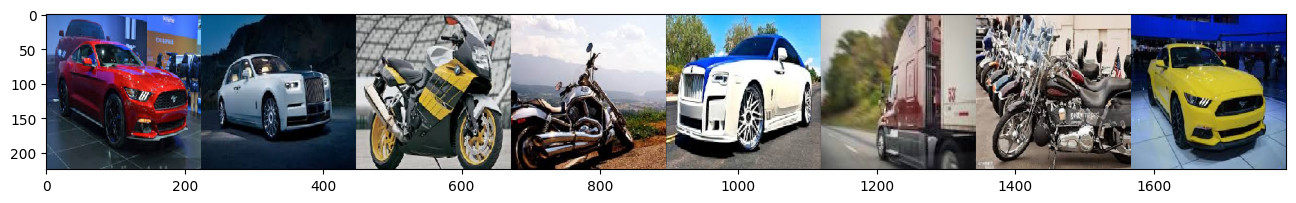

In [12]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(8)]
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

### First training a neural net from scratch



In [13]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 222, 222, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 109, 109, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 52, 52, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,209,058 (4.61 MB)

 Trainable params: 1,209,058 (4.61 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=128,
                    epochs=10,
                    validation_data=(x_val, y_val))

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 91s 10s/step - accuracy: 0.5136 - loss: 0.7044 - val_accuracy: 0.7185 - val_loss: 0.6432
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 144s 10s/step - accuracy: 0.7027 - loss: 0.5929 - val_accuracy: 0.7857 - val_loss: 0.4633
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 134s 9s/step - accuracy: 0.7644 - loss: 0.4666 - val_accuracy: 0.8025 - val_loss: 0.4133
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.8394 - loss: 0.3831 - val_accuracy: 0.8739 - val_loss: 0.3447
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.8727 - loss: 0.3066 - val_accuracy: 0.8697 - val_loss: 0.2998
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.8781 - loss: 0.2906 - val_accuracy: 0.8782 - val_loss: 0.2767
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 81s 9s/step - accuracy: 0.8927 - loss: 0.2535 - val_accuracy: 0.9118 - val_loss: 0.2213
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 95s 11s/step - accuracy: 0.9027 - loss: 0.2221 - val_accuracy: 0.9160 - val_loss: 0.2042
Ep

Let's plot the validation loss and validation accuracy over time.

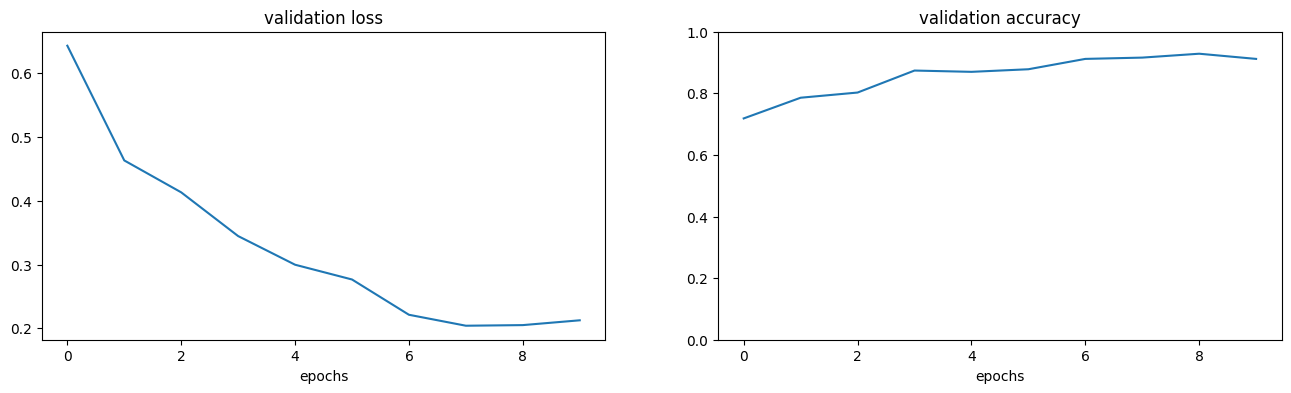

In [15]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.29409849643707275
Test accuracy: 0.866108775138855


In [17]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


In [19]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc1 (Dense)                          │ (None, 4096)                │     102,764,544 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 8,194 (32.01 KB)

 Non-trainable params: 134,260,544 (512.16 MB)

In [20]:
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 906s 103s/step - accuracy: 0.4892 - loss: 1.0426 - val_accuracy: 0.5420 - val_loss: 0.6093
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 918s 102s/step - accuracy: 0.7454 - loss: 0.4969 - val_accuracy: 0.9160 - val_loss: 0.3812
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 921s 103s/step - accuracy: 0.9385 - loss: 0.3377 - val_accuracy: 0.9286 - val_loss: 0.2958
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 846s 95s/step - accuracy: 0.9549 - loss: 0.2535 - val_accuracy: 0.9496 - val_loss: 0.2234
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 891s 102s/step - accuracy: 0.9407 - loss: 0.2158 - val_accuracy: 0.9538 - val_loss: 0.2010
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 926s 102s/step - accuracy: 0.9520 - loss: 0.1947 - val_accuracy: 0.9496 - val_loss: 0.1777
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 920s 102s/step - accuracy: 0.9683 - loss: 0.1572 - val_accuracy: 0.9496 - val_loss: 0.1763
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 872s 95s/step - accuracy: 0.9692 - loss: 0.1501 - val_accuracy: 0.9538 - val

In [21]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

In [22]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.1302555650472641
Test accuracy: 0.9832636117935181


To predict a new image, simply run the following code to get the probabilities for each class.

In [ ]:
img, x = get_image('insert path here')
probabilities = model_new.predict([x])
